### 1. Imports and Data Loading

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# MICE
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

import shap


PATH = "garments_worker_productivity.csv"
df = pd.read_csv(PATH)
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


### 2. Missing Value Analysis
- Check missing patterns by department/team
- Visualize NaN distribution and correlation with productivity


=== Missing Value Analysis ===

[Overall Missing Summary]
                        Missing_Count  Missing_Rate(%)
date                               0             0.00
quarter                            0             0.00
department                         0             0.00
day                                0             0.00
team                               0             0.00
targeted_productivity              0             0.00
smv                                0             0.00
wip                              506            42.27
over_time                          0             0.00
incentive                          0             0.00
idle_time                          0             0.00
idle_men                           0             0.00
no_of_style_change                 0             0.00
no_of_workers                      0             0.00
actual_productivity                0             0.00

[Missing Ratio of 'wip' by Department (%)]
 department
finishing     100.0


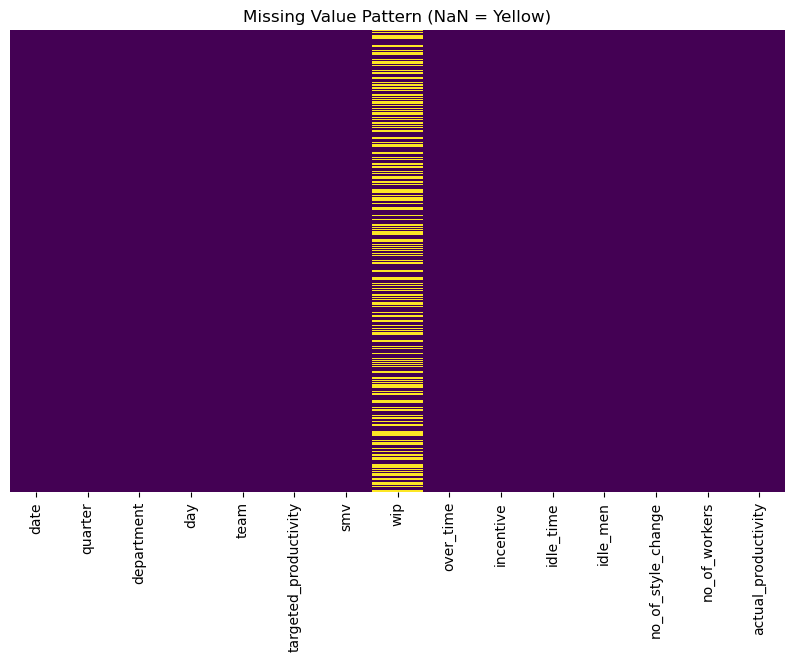


Correlation (wip vs actual_productivity): 0.1311


In [2]:
print("\n=== Missing Value Analysis ===")

# Overall missing count and ratio per column
missing_summary = df.isna().sum().to_frame("Missing_Count")
missing_summary["Missing_Rate(%)"] = (df.isna().mean() * 100).round(2)
print("\n[Overall Missing Summary]\n", missing_summary)

# Missing ratio of 'wip' by department
dept_missing = df.groupby("department")["wip"].apply(lambda x: x.isna().mean() * 100).sort_values(ascending=False)
print("\n[Missing Ratio of 'wip' by Department (%)]\n", dept_missing)

# Missing ratio of 'wip' by team 
team_missing = df.groupby("team")["wip"].apply(lambda x: x.isna().mean() * 100).sort_values(ascending=False)
print("\n[Missing Ratio of 'wip' by Team (Top 10) (%)]\n", team_missing.head(10))

# Visualize missing pattern
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Value Pattern (NaN = Yellow)")
plt.show()

# Correlation between 'wip' and actual productivity
corr_value = df["wip"].corr(df["actual_productivity"])
print(f"\nCorrelation (wip vs actual_productivity): {corr_value:.4f}")


### 3. Functions for Model Training and SHAP Analysis

- Preprocessing: Removes missing targets, performs one-hot encoding, and drops irrelevant columns (to_drop).

- MICE-Based Imputation: Uses IterativeImputer with LGBMRegressor to fill missing wip values.

- Model Setup: three regression models — LGBM, XGB, and RandomForest.

- Performance Evaluation: RMSE, MAE, and R² for model comparison.

- SHAP Interpretation: TreeExplainer for tree models and provides summary visualizations for feature importance.

In [3]:
target = "actual_productivity"

num_cols = [
    "targeted_productivity", "incentive", "no_of_workers",
    "smv", "over_time", "wip"
]
cat_cols = ["day", "quarter", "department"]  

# 존재 시 제거할 더미 컬럼들
to_drop = [
    "day_Sunday", "day_Wednesday", "day_Saturday", "day_Thursday", "day_Tuesday",
    "quarter_Quarter2", "quarter_Quarter3", "quarter_Quarter4",
    "department_sweing", "no_of_style_change"
]

def load_data_use_target(df_in: pd.DataFrame) -> pd.DataFrame:
    """Remove rows with missing target."""
    if target in df_in.columns:
        return df_in[df_in[target].notna()].copy()
    return df_in.copy()

def encode_after_removal(df_in: pd.DataFrame) -> pd.DataFrame:
    """One-hot encode (day/quarter/department) and drop to_drop columns. (team excluded)"""
    use_cols = [c for c in (num_cols + cat_cols + [target]) if c in df_in.columns]
    df_use = df_in[use_cols].copy()
    df_enc = pd.get_dummies(df_use, columns=["day","quarter","department"], drop_first=True)
    drop_cols = [c for c in to_drop if c in df_enc.columns]
    df_enc = df_enc.drop(columns=drop_cols, errors="ignore")
    return df_enc

def impute_wip_mice_based(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    IterativeImputer (MICE) to impute 'wip'.
    - One-hot for day/quarter/department
    - estimator: LGBMRegressor
    - Only 'wip' column is written back to the original df.
    """
    df_out = df_in.copy()
    feat_for_wip = [
        "targeted_productivity","smv","over_time","incentive","no_of_workers",
        "day","quarter","department","wip"
    ]
    avail = [c for c in feat_for_wip if c in df_out.columns]
    tmp = df_out[avail].copy()
    tmp_enc = pd.get_dummies(tmp, columns=[c for c in ["day","quarter","department"] if c in tmp.columns],
                             drop_first=True)

    imp = IterativeImputer(
        estimator=LGBMRegressor(random_state=42),
        max_iter=10,
        sample_posterior=False,
        random_state=42
    )
    imputed = imp.fit_transform(tmp_enc)
    tmp_imp = pd.DataFrame(imputed, columns=tmp_enc.columns, index=tmp_enc.index)

    if "wip" in tmp_imp.columns:
        df_out.loc[:, "wip"] = tmp_imp["wip"].values
    return df_out

def get_models():
    return {
        "LGBM": LGBMRegressor(
            n_estimators=400, learning_rate=0.03,
            max_depth=7, subsample=0.9, colsample_bytree=0.9, random_state=42
        ),
        "XGB": XGBRegressor(
            n_estimators=400, learning_rate=0.03,
            max_depth=7, subsample=0.9, colsample_bytree=0.9,
            objective="reg:squarederror", random_state=42
        ),
        "RF": RandomForestRegressor(
            n_estimators=600, max_depth=10, random_state=42, n_jobs=-1
        ),
    }

def train_and_eval(df_features: pd.DataFrame, version_tag: str = "") -> pd.DataFrame:
    y = df_features[target]
    X = df_features.drop(columns=[target])

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

    models = get_models()
    rows, fitted = [], {}
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        pred = model.predict(X_te)
        rmse = mean_squared_error(y_te, pred, squared=False)
        mae  = mean_absolute_error(y_te, pred)
        r2   = r2_score(y_te, pred)
        rows.append((version_tag, name, rmse, mae, r2))
        fitted[name] = (model, (X_tr, X_te, y_tr, y_te))

    res = pd.DataFrame(rows, columns=["Version","Model","RMSE","MAE","R2"]).sort_values(["Version","RMSE"])
    return res, fitted

def get_tree_explainer(model, X_bg: pd.DataFrame):
    """Prefer TreeExplainer; fallback to model-agnostic Explainer."""
    try:
        return shap.TreeExplainer(model)
    except Exception:
        masker = shap.maskers.Independent(
            X_bg.sample(min(len(X_bg), 500), random_state=42)
        )
        return shap.Explainer(model.predict, masker)

def shap_analysis(model, X_tr: pd.DataFrame, X_te: pd.DataFrame, label: str, topk: int = 10, sample_for_speed: int = 800):
    X_show = X_te.sample(sample_for_speed, random_state=42) if len(X_te) > sample_for_speed else X_te.copy()
    explainer = get_tree_explainer(model, X_tr)
    sv = explainer(X_show)

    mean_abs = np.abs(sv.values).mean(axis=0)
    order = np.argsort(-mean_abs)
    print(f"\n[SHAP Top-{topk}] {label}")
    for i in range(min(topk, len(order))):
        print(f"{i+1:>2}. {X_show.columns[order[i]]:28s}  mean|SHAP|={float(mean_abs[order[i]]):.6f}")

    plt.figure(figsize=(8,5))
    shap.summary_plot(sv.values, X_show, feature_names=X_show.columns, show=False)
    plt.title(f"SHAP Summary — {label}")
    plt.tight_layout()
    plt.show()


### 4. UseMICE_WIP vs. DropWIP
- UseMICE_WIP: Missing values in the WIP column are imputed using MICE (Iterative Imputer), and the imputed WIP values are included as a feature for model training.

- DropWIP: The WIP column is completely removed from the feature set before training (no imputation performed).

In [4]:
# Version A (UseMICE_WIP)

shap.initjs()

df_use = load_data_use_target(df)         
df_A = impute_wip_mice_based(df_use.copy())
df_enc_A = encode_after_removal(df_A)

res_A, fitted_A = train_and_eval(df_enc_A, version_tag="UseMICE_WIP")
print("\n=== Model Comparison (After-Removal Features) — A Only ===")
print(res_A)


# Version B (DropWIP)

df_B = load_data_use_target(df).copy()
df_enc_B = encode_after_removal(df_B)
if "wip" in df_enc_B.columns:
    df_enc_B = df_enc_B.drop(columns=["wip"])

res_B, fitted_B = train_and_eval(df_enc_B, version_tag="DropWIP")
print("\n=== Model Comparison (After-Removal Features) — B Only ===")
print(res_B)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 16
[LightGBM] [Info] Start training from score 0.729632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 16
[LightGBM] [Info] Start training from score 15.062172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 11

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 16
[LightGBM] [Info] Start training from score 0.167920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 16
[LightGBM] [Info] Start training from score 0.214703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 16
[LightGBM] [Info] Start training from score 0.729632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Inf

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 16
[LightGBM] [Info] Start training from score 0.279866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 957, number of used features: 8
[LightGBM] [Info] Start training from score 0.732472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain


=== Model Comparison (After-Removal Features) — A Only ===
       Version Model      RMSE       MAE        R2
2  UseMICE_WIP    RF  0.109372  0.069271  0.549483
1  UseMICE_WIP   XGB  0.117458  0.071738  0.480415
0  UseMICE_WIP  LGBM  0.118164  0.076162  0.474143
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 957, number of used features: 7
[LightGBM] [Info] Start training from score 0.732472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### 5. Model Comparison & Best Model Selection
- Among the three models (LGBM, XGB, RF), Random Forest (RF) showed the best overall performance
- DropWIP (RF) slightly outperformed UseMICE_WIP (RF), indicating that removing WIP gave a more accurate and stable model.

In [5]:
res = pd.concat([res_A, res_B], ignore_index=True)
print("\n=== Model Comparison (After-Removal Features) ===")
print(res)

best_by_version = res.sort_values(["Version","RMSE"]).groupby("Version", as_index=False).first()
print("\n[Best per Version]")
print(best_by_version)

best_A_name = best_by_version.query("Version=='UseMICE_WIP'")["Model"].iloc[0]
best_B_name = best_by_version.query("Version=='DropWIP'")["Model"].iloc[0]

best_A_name, best_B_name


=== Model Comparison (After-Removal Features) ===
       Version Model      RMSE       MAE        R2
0  UseMICE_WIP    RF  0.109372  0.069271  0.549483
1  UseMICE_WIP   XGB  0.117458  0.071738  0.480415
2  UseMICE_WIP  LGBM  0.118164  0.076162  0.474143
3      DropWIP    RF  0.107625  0.067068  0.563761
4      DropWIP  LGBM  0.111924  0.072024  0.528219
5      DropWIP   XGB  0.113073  0.068205  0.518482

[Best per Version]
       Version Model      RMSE       MAE        R2
0      DropWIP    RF  0.107625  0.067068  0.563761
1  UseMICE_WIP    RF  0.109372  0.069271  0.549483


('RF', 'RF')

### 6. SHAP Interpretation

- In both models, targeted_productivity, incentive, and no_of_workers are the top three drivers of productivity prediction.
- DropWIP (RF) shows slightly stronger and cleaner feature influence patterns, consistent with its better RMSE/R² performance.

- WIP contributes little even after imputation — confirming that removing it doesn’t harm predictive power.

- Overall, core productivity, incentive, and workforce size dominate model behavior, while categorical features like department_finishing and quarter_Quarter5 have minor effects.


===== Best Model Report — UseMICE_WIP (RF) =====
RMSE: 0.109372 | MAE: 0.069271 | R²: 0.549483

[SHAP Top-10] UseMICE_WIP — RF
 1. targeted_productivity         mean|SHAP|=0.058778
 2. incentive                     mean|SHAP|=0.037328
 3. no_of_workers                 mean|SHAP|=0.028630
 4. smv                           mean|SHAP|=0.028211
 5. over_time                     mean|SHAP|=0.013761
 6. department_finishing          mean|SHAP|=0.013040
 7. wip                           mean|SHAP|=0.008246
 8. quarter_Quarter5              mean|SHAP|=0.000991


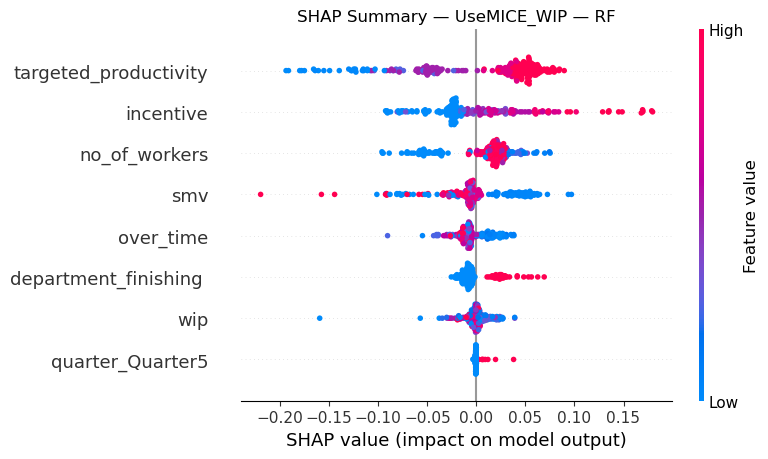


===== Best Model Report — DropWIP (RF) =====
RMSE: 0.107625 | MAE: 0.067068 | R²: 0.563761

[SHAP Top-10] DropWIP — RF
 1. targeted_productivity         mean|SHAP|=0.055309
 2. incentive                     mean|SHAP|=0.044149
 3. smv                           mean|SHAP|=0.032703
 4. no_of_workers                 mean|SHAP|=0.032646
 5. over_time                     mean|SHAP|=0.018598
 6. department_finishing          mean|SHAP|=0.014759
 7. quarter_Quarter5              mean|SHAP|=0.001939


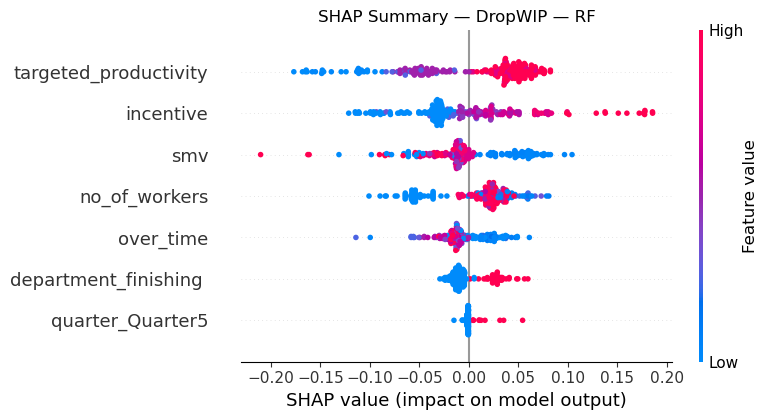

In [6]:
# SHAP for Best (UseMICE_WIP)

yA = df_enc_A[target]; XA = df_enc_A.drop(columns=[target])
XA_tr, XA_te, yA_tr, yA_te = train_test_split(XA, yA, test_size=0.2, random_state=42)

modelA = get_models()[best_A_name]
modelA.fit(XA_tr, yA_tr)

predA = modelA.predict(XA_te)
rmseA = mean_squared_error(yA_te, predA, squared=False)
maeA  = mean_absolute_error(yA_te, predA)
r2A   = r2_score(yA_te, predA)

print(f"\n===== Best Model Report — UseMICE_WIP ({best_A_name}) =====")
print(f"RMSE: {rmseA:.6f} | MAE: {maeA:.6f} | R²: {r2A:.6f}")

shap_analysis(modelA, XA_tr, XA_te, label=f"UseMICE_WIP — {best_A_name}")



# SHAP for Best (DropWIP)

yB = df_enc_B[target]; XB = df_enc_B.drop(columns=[target])
XB_tr, XB_te, yB_tr, yB_te = train_test_split(XB, yB, test_size=0.2, random_state=42)

modelB = get_models()[best_B_name]
modelB.fit(XB_tr, yB_tr)

predB = modelB.predict(XB_te)
rmseB = mean_squared_error(yB_te, predB, squared=False)
maeB  = mean_absolute_error(yB_te, predB)
r2B   = r2_score(yB_te, predB)

print(f"\n===== Best Model Report — DropWIP ({best_B_name}) =====")
print(f"RMSE: {rmseB:.6f} | MAE: {maeB:.6f} | R²: {r2B:.6f}")

shap_analysis(modelB, XB_tr, XB_te, label=f"DropWIP — {best_B_name}")
